In [7]:
import torch
from denoising_diffusion_pytorch import Unet1D, GaussianDiffusion1D, Trainer1D, Dataset1D
import matplotlib.pyplot as plt
import numpy as np


N_TRAINING_EXAMPLES = 1000
SEQ_LENGTH = 128

def generate_sine_sequences(N, seq_length=128,
                            freq_range=(1, 10),
                            phase_range=(0, 2 * torch.pi),
                            amp_range=(5.0, 10.0)):
    # Create a tensor representing the time axis
    t = torch.linspace(0, 2 * torch.pi, seq_length).unsqueeze(0)  # Shape: (1, seq_length)

    # Sample random frequencies and phases
    freqs = torch.rand(N, 1) * (freq_range[1] - freq_range[0]) + freq_range[0]  # Shape: (N, 1)
    phases = torch.rand(N, 1) * (phase_range[1] - phase_range[0]) + phase_range[0]  # Shape: (N, 1)
    amplitudes = torch.rand(N, 1) * (amp_range[1] - amp_range[0]) + amp_range[0]  # Shape: (N, 1)

    # Generate sine waves
    sine_waves = amplitudes * torch.sin(freqs * t + phases)  # Shape: (N, seq_length)

    # Add channel dimension to get shape (N, 1, seq_length)
    return sine_waves.unsqueeze(1)

def z_score_normalize(x, eps=1e-8, dim=None):
    mean = x.mean(dim=dim, keepdim=True)  # Compute mean
    std = x.std(dim=dim, keepdim=True)  # Compute standard deviation
    
    return (x - mean) / (std + eps), mean, std + eps # Normalize

def generate_normalized_sine_sequences(N, seq_length=128,
                                       freq_range=(1, 10),
                                       phase_range=(0, 2 * torch.pi),
                                       amp_range=(5.0, 10.0)):

    # Generate sine sequences
    sine_sequences = generate_sine_sequences(N, seq_length, freq_range, phase_range, amp_range)
    
    # Normalize the sequences
    normalized_sequences, mean, std = z_score_normalize(sine_sequences, dim=None)
    
    # Squish to (0, 1)
    normalized_sequences = torch.sigmoid(normalized_sequences)
    
    return normalized_sequences, mean, std

def denormalize_generated_sequences(generated_sequences, mean, std):
    denormalized_sequences = ( torch.logit(generated_sequences) ) * std + mean
    
    return denormalized_sequences

In [9]:
model = Unet1D(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    channels = 1
)

diffusion = GaussianDiffusion1D(
    model,
    seq_length = SEQ_LENGTH,
    timesteps = 500,
    objective = 'pred_noise',
    auto_normalize = True
)

Training sequence shape: torch.Size([1000, 1, 128])


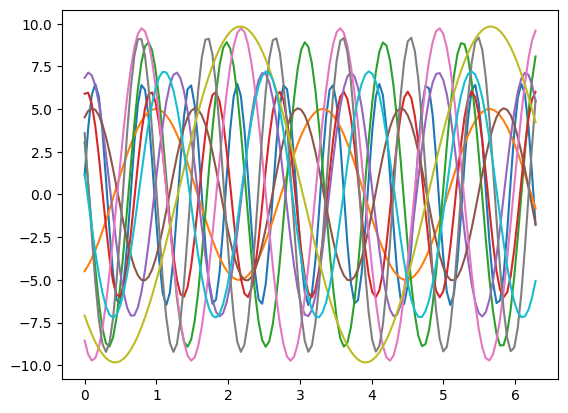

In [10]:
training_seq, training_mean, training_std = generate_normalized_sine_sequences(N_TRAINING_EXAMPLES, seq_length=SEQ_LENGTH)

print("Training sequence shape:", training_seq.shape) # (N_TRAINING_EXAMPLES, 1, SEQ_LENGTH)

example_sequences = training_seq[torch.randint(0, N_TRAINING_EXAMPLES, (10,))]
denormalized_example_sequences = denormalize_generated_sequences(example_sequences, training_mean, training_std)
denormalized_example_sequences = np.squeeze(denormalized_example_sequences.cpu().numpy())

fig, ax = plt.subplots()

ax.plot(np.linspace(0, 2*np.pi, 128), denormalized_example_sequences.T)
plt.show()

In [11]:
dataset = Dataset1D(training_seq)  # this is just an example, but you can formulate your own Dataset and pass it into the `Trainer1D` below

trainer = Trainer1D(
    diffusion,
    dataset = dataset,
    train_batch_size = 32,
    train_lr = 1e-4,
    train_num_steps = 500,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
)

trainer.train()

  0%|          | 0/500 [00:00<?, ?it/s]

training complete


In [ ]:
sampled_seq = diffusion.sample(batch_size = 10)
print("Sampled sequence shape:", sampled_seq.shape) # (10, 1, SEQ_LENGTH)

denormalized_samples = denormalize_generated_sequences(sampled_seq.cpu(), training_mean, training_std)
denormalized_samples = np.squeeze(denormalized_samples.cpu().numpy())


fig, ax = plt.subplots()
ax.plot(np.linspace(0, 2*np.pi, SEQ_LENGTH), denormalized_samples.T)
plt.show()